In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as smp
from tqdm import tqdm
from sympy import Symbol, symbols
from pathlib import Path
import centrex_TlF as centrex
import matplotlib.pyplot as plt
from sympy.utilities import lambdify
import matplotlib as mpl
from julia import Main

In [2]:
from optical_bloch.utils.general import flatten
from optical_bloch import Hamiltonian, Dissipator, BlochEquations

In [3]:
energies = smp.symbols("E10 E11 E12 E20 E21 E22 Ee", real = True)
ω1, ω2 = smp.symbols("ω1 ω2", real = True)
Ω1x, Ω1z = smp.symbols("Ω1x Ω1z", real = True)
Ω2x, Ω2z = smp.symbols("Ω2x Ω2z", real = True)

δ1, δ2 = smp.symbols("δ1 δ2", real = True)
Δ = smp.symbols("Δ", real = True)

In [4]:
ham = Hamiltonian(len(energies))
ham.addEnergies(energies)
ham.addCoupling(0,6,Ω1x, ω1)
ham.addCoupling(1,6,Ω1z, ω1)
ham.addCoupling(2,6,Ω1x, ω1)
ham.addCoupling(3,6,Ω2x, ω2)
ham.addCoupling(4,6,Ω2z, ω2)
ham.addCoupling(5,6,Ω2x, ω2)

ham.eqnTransform()
ham.defineZero(energies[-1])
ham.defineStateDetuning(0,6,δ1)
ham.defineStateDetuning(1,6,δ1)
ham.defineStateDetuning(2,6,δ1)
ham.defineStateDetuning(3,6,δ2)
ham.defineStateDetuning(4,6,δ2)
ham.defineStateDetuning(5,6,δ2)
ham.transformed = ham.transformed.subs(δ2, -Δ+δ1)
for energy in energies:
    ham.transformed = ham.transformed.subs(energy, 0)

In [5]:
ga = Symbol(u'Γ1', real = True)
gb = Symbol(u'Γ2', real = True)
dis = Dissipator(len(energies))
dis.addDecay(6,0,ga)
dis.addDecay(6,1,ga)
dis.addDecay(6,2,ga)
dis.addDecay(6,3,gb)
dis.addDecay(6,4,gb)
dis.addDecay(6,5,gb)

In [6]:
bloch = BlochEquations(len(energies), dis.density_matrix, ham.transformed, dis.dissipator)

In [7]:
bloch.equations.rhs.free_symbols

{t, Γ1, Γ2, Δ, Ω1x, Ω1z, Ω2x, Ω2z, δ1}

In [8]:
Main.eval("""
    using Distributed
    using ProgressMeter
    addprocs(7)
""")

array([2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [9]:
Main.eval("""
    const channel = RemoteChannel(()->Channel{Int}(1))
    @everywhere const channel = $channel
""")

In [10]:
Main.eval("""
@everywhere begin
    using Distributed
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    using ModelingToolkit
    using ModelingToolkit: varmap_to_vars
end
""")

In [11]:
Main.eval("""
@everywhere begin
    @variables t ρ[1:7,1:7](t)
    @parameters icomplex
    D = Differential(t)
end
tmp = 0
""");

In [12]:
for var in bloch.hamiltonian.free_symbols:
    if "Ω" in str(var):
        Main.eval(f"""
        @everywhere @variables {var}(t)
        tmp = 0
        """);
    else:
        Main.eval(f"""
            @everywhere @parameters {var}
            tmp = 0
        """);
for var in bloch.dissipator.free_symbols:
    if str(var) != "t":
        Main.eval(f"""
            @everywhere @parameters {var}
            tmp = 0
        """);
        
H = "H = [\n"
for idx in range(bloch.hamiltonian.shape[0]):
    for idy in range(bloch.hamiltonian.shape[1]):
        H += f"{str(bloch.hamiltonian[idx,idy])} "
    H += "\n"
H += "]"

L = "L = [\n"
for idx in range(bloch.dissipator.shape[0]):
    for idy in range(bloch.dissipator.shape[1]):
        val = str(bloch.dissipator[idx,idy])
        val = val.replace("conjugate", "conj")
        for i in range(bloch.density_matrix.shape[0]):
            for j in range(bloch.density_matrix.shape[1]):
                val = val.replace(f"conj({bloch.density_matrix[i,j]})", f"ρ[{j+1},{i+1}]")
                val = val.replace(str(bloch.density_matrix[i,j]), f"ρ[{i+1},{j+1}]")
        L += f"{val} "
    L += "\n"
L += "]"

Main.eval(f"""
@everywhere begin
    {H}
    {L}
    tmp = 0;
end
""");


In [13]:
Main.eval("""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:7 for idy in 1:7]
    tmp = 0
end
""");

In [14]:
Main.eval("""
@everywhere begin
    @variables Pl(t) Ω1x(t) Ω1z(t) Ω2x(t) Ω2z(t)
    @parameters Ωl ωp ϕp
    append!(eqns, [Pl ~ sin(ωp*t+ϕp)])
    append!(eqns, [Ω1x ~ Ωl * (1+Pl)/2])
    append!(eqns, [Ω1z ~ Ωl * (1-Pl)/2])
    append!(eqns, [Ω2x ~ Ωl * (1+Pl)/2])
    append!(eqns, [Ω2z ~ Ωl * (1-Pl)/2])
end
""");

In [15]:
Main.eval("@everywhere @named system = ODESystem(eqns)");
Main.eval("@everywhere system = structural_simplify(system)");
# Main.eval("@everywhere system = $system")

In [16]:
# Main.eval("""
#     p = [Ω1x => 0, Ω1z => 1, Ω2x => 0, Ω2z => 1, Δ => 0.1, δ1 => 0, Γ1 => 1, Γ2 => 1, icomplex => 1im]
#     tmp = 0;
# """);

In [17]:
Main.eval("""
    @everywhere p = [Ωl => 0.5, ωp => 1, ϕp => 0, Δ => 0.05, δ1 => 0, Γ1 => 1, Γ2 => 1, icomplex => 1im]
    tmp = 0;
""");

In [18]:
Main.eval("""
@everywhere begin
    ρᵢ = zeros(ComplexF64,7,7)
    ρᵢ[1,1] = 1
    u0 = [ρ[idx,idy] => ρᵢ[idx,idy] for idx in 1:7 for idy in 1:7]
    tmp = 0;
end
""");

In [19]:
Main.eval("""
    @everywhere prob = ODEProblem(system, u0, (0., 100.), p, jac = true)
    sol = solve(prob, Tsit5(), reltol = 1e-7, abstol = 1e-4);
""");
sol = np.asarray(Main.eval("sol.u"))
indices = [bloch.levels*i + i for i in range(bloch.levels)]
pops = sol[:,indices].real
t_array = Main.eval("sol.t")

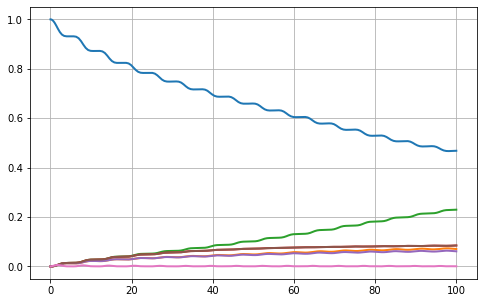

In [20]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array, pops, lw = 2);
ax.grid(True)

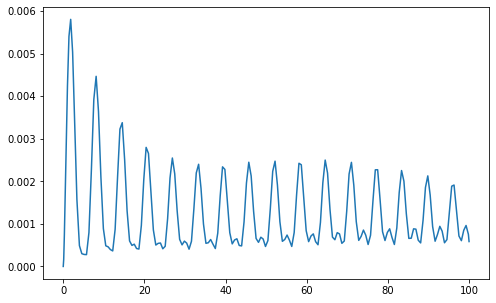

In [21]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array, pops[:,-1]);

## Population in a single state (1st state)
Scanning the polarization switching frequency and energy splitting for a fixed rabi rate and detuning

In [22]:
Δis = np.linspace(0,1,201)
ωis = np.linspace(0,1,201)

In [23]:
values = [Δis, ωis]
params = np.array(np.meshgrid(*values)).T.reshape(-1,len(values))
Main.params = params
Main.eval("@everywhere params = $params")

In [24]:
Main.eval("println(parameters(system))")

In [25]:
Main.eval(f"""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = ModelingToolkit.varmap_to_vars([Δ=>params[i,1], ωp=>params[i,2],
        Ωl => 0.5, ϕp => 0, δ1 => 0, Γ1 => 1, Γ2 => 1, icomplex => 1im],
        parameters(system)))
end
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sol.u[j][49]) for j in 1:size(sol)[2]]), false
end
""")

In [26]:
Main.eval("""
    ens_prob = EnsembleProblem(prob, output_func = output_func, prob_func = prob_func)
""");

In [27]:
%%time
Main.eval(f"""
    sol = solve(ens_prob, Tsit5(), EnsembleDistributed(), reltol = 1e-7, abstol = 1e-4, 
    trajectories = size(params)[1]);
    tmp = 0;
""");

Wall time: 6min 21s


0

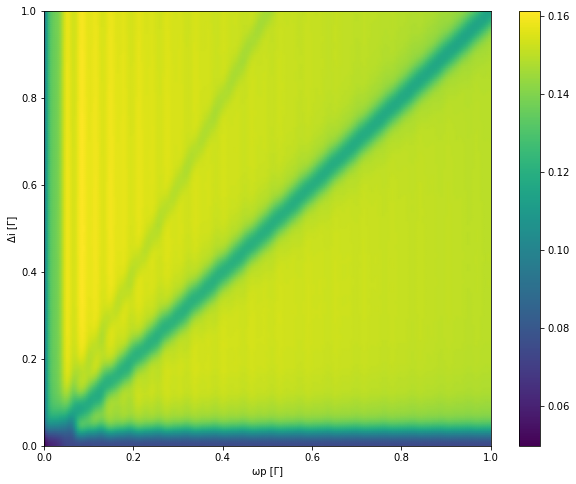

In [28]:
X,Y = np.meshgrid(*values[::-1])
sol = np.asarray(Main.eval("sol")).reshape(len(Δis),len(ωis))

fig, ax = plt.subplots(figsize = (10,8))
cax = ax.pcolormesh(X,Y,sol, shading = 'gouraud')
fig.colorbar(cax)
ax.set_xlabel('ωp [Γ]')
ax.set_ylabel('Δi [Γ]');

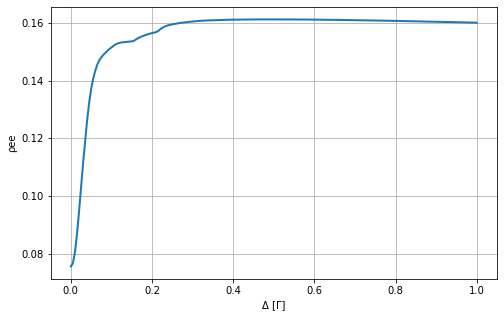

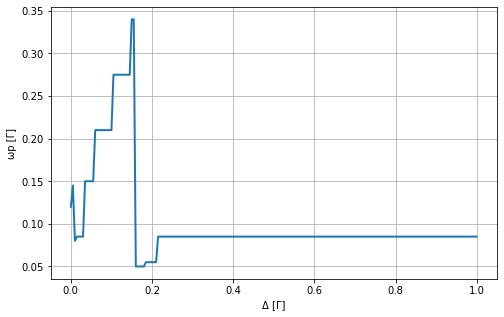

In [29]:
ωpmax = []
excited_population_max = []
for x in Δis:
    m = Y == x
    ωpmax.append(X[m][np.argmax(sol[m])])
    excited_population_max.append(np.max(sol[m]))
    
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Δis, excited_population_max, lw = 2)
ax.grid(True)
ax.set_xlabel('Δ [Γ]')
ax.set_ylabel('ρee')

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Δis, ωpmax, lw = 2)
ax.grid(True)
ax.set_xlabel('Δ [Γ]')
ax.set_ylabel('ωp [Γ]');

## Population in a single state (1st state)
Scanning the polarization switching frequency and energy splitting and rabi rate for a fixed detuning

In [ ]:
Δis = np.linspace(0,1,201)
ωis = np.linspace(0,1,201)
Ωis = np.linspace(0.1,1,10)

In [ ]:
values = [Δis, ωis, Ωis]
params = np.array(np.meshgrid(*values)).T.reshape(-1,len(values))
Main.params = params
Main.eval("@everywhere params = $params")

In [ ]:
Main.eval(f"""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = ModelingToolkit.varmap_to_vars([Δ=>params[i,1], ωp=>params[i,2],
        Ωl => params[i,3], ϕp => 0, δ1 => 0, Γ1 => 1, Γ2 => 1, icomplex => 1im],
        parameters(system)))
end
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sol.u[j][49]) for j in 1:size(sol)[2]]), false
end
""")

In [ ]:
Main.eval("""
    ens_prob = EnsembleProblem(prob, output_func = output_func, prob_func = prob_func)
""");

In [ ]:
%%time
Main.eval(f"""
    sol = solve(ens_prob, Tsit5(), EnsembleDistributed(), reltol = 1e-7, abstol = 1e-4, 
    trajectories = size(params)[1]);
    tmp = 0;
""");

In [ ]:
sol_unshaped = np.asarray(Main.eval("sol"))
sol = np.asarray(Main.eval("sol")).reshape(len(Ωis),len(Δis),len(ωis))

In [ ]:
X,Y = np.meshgrid(*values[::-1][1:])
for s in sol:
    fig, ax = plt.subplots(figsize = (10,8))
    cax = ax.pcolormesh(X,Y,s, shading = 'gouraud')
    fig.colorbar(cax)
    ax.set_xlabel('ωp [Γ]')
    ax.set_ylabel('Δi [Γ]');

In [ ]:
Δi = 0.05

cmap = mpl.cm.get_cmap("plasma")
dy = 0.

maxval = np.max(sol_unshaped[params[:,0]==Δi])
    
fig, ax = plt.subplots(figsize = (8,5))
for i,Ωi in enumerate(Ωis):
    m = (params[:,0] == Δi) & (params[:,2] == Ωi)
    ax.plot(ωis, sol_unshaped[m]+dy*i, lw = 2, color = cmap(i/len(Ωis)))
#     ax.fill_between(ωis, dy*i, sol_unshaped[m]+dy*i, color = cmap(i/len(Ωis)), alpha = 1, zorder = 100-i)
    
ax.set_xlabel('ωp [Γ]')
ax.set_ylabel("ρ$_{ee}$")
ax.grid(True);

## Population spread out evenly
Scanning the detuning and rabi rate for a fixed splitting and polarization switching frequency

In [30]:
Main.eval("""
@everywhere begin
    ρᵢ = zeros(ComplexF64,7,7)
    ρᵢ[1,1] = 1/6
    ρᵢ[2,2] = 1/6
    ρᵢ[3,3] = 1/6
    ρᵢ[4,4] = 1/6
    ρᵢ[5,5] = 1/6
    ρᵢ[6,6] = 1/6
    u0 = [ρ[idx,idy] => ρᵢ[idx,idy] for idx in 1:7 for idy in 1:7]
    prob = ODEProblem(system, u0, (0., 100.), p, jac = true)
end
""");

In [31]:
δis = np.linspace(-2,2,51)
Ωis = np.linspace(0.1,1,10)

In [32]:
values = [δis, Ωis]
params = np.array(np.meshgrid(*values)).T.reshape(-1,len(values))
Main.params = params
Main.eval("@everywhere params = $params")

In [33]:
Main.eval(f"""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = ModelingToolkit.varmap_to_vars([Δ=>0.5, ωp=>0.5,
        Ωl => params[i,2], ϕp => 0, δ1 => params[i,1], Γ1 => 1, Γ2 => 1, icomplex => 1im],
        parameters(system)))
end
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sol.u[j][49]) for j in 1:size(sol)[2]]), false
end
""")

In [34]:
Main.eval("""
    ens_prob = EnsembleProblem(prob, output_func = output_func, prob_func = prob_func)
""");

In [35]:
%%time
Main.eval(f"""
    sol = solve(ens_prob, Tsit5(), EnsembleDistributed(), reltol = 1e-7, abstol = 1e-4, 
    trajectories = size(params)[1]);
    tmp = 0;
""");

Wall time: 4.74 s


0

In [36]:
sol_unshaped = np.asarray(Main.eval("sol"))
sol = np.asarray(Main.eval("sol")).reshape(*[len(val) for val in values])

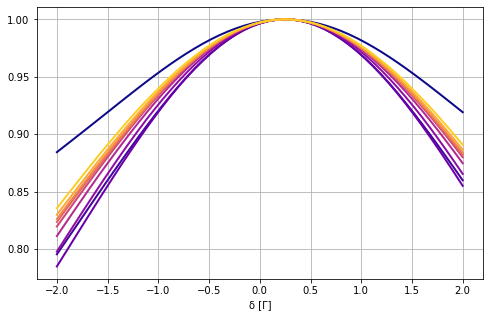

In [37]:
cmap = mpl.cm.get_cmap("plasma")

fig, ax = plt.subplots(figsize = (8,5))
for i in range(10):
    ax.plot(δis, sol[:,i]/sol[:,i].max(), lw = 2, color = cmap(i/len(Ωis)))
    ax.set_xlabel("δ [Γ]");
ax.grid(True)

## Population spread out evenly
Scanning the polarization switching frequency, rabi rate and splitting for a fixed detuning

In [60]:
Δis = np.linspace(0,1,101)
ωis = np.linspace(0,1,101)
Ωis = np.linspace(0.1,1,10)

In [61]:
Main.eval("""
@everywhere function output_func_progress(sol, i)
    put!(channel, 1)
    return output_func(sol, i)
end
""")

In [62]:
values = [Δis, ωis, Ωis]
params = np.array(np.meshgrid(*values)).T.reshape(-1,len(values))
Main.params = params
Main.eval("@everywhere params = $params")

In [64]:
Main.eval(f"""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = ModelingToolkit.varmap_to_vars([Δ=>params[i,1], ωp=>params[i,2],
        Ωl => params[i,3], ϕp => 0, δ1 => 0, Γ1 => 1, Γ2 => 1, icomplex => 1im],
        parameters(system)))
end
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sol.u[j][49]) for j in 1:size(sol)[2]]), false
end
""")

In [65]:
Main.eval("""
    ens_prob = EnsembleProblem(prob, output_func = output_func_progress, prob_func = prob_func)
""");

In [66]:
Main.eval("""
progress = Progress(size(params)[1], showspeed = true)
n_trajectories = size(params)[1]
@sync sol = begin
    @async begin
        tasksdone = 0
        while tasksdone < n_trajectories
            tasksdone += take!(channel)
            update!(progress, tasksdone)
        end
    end
    @async begin
        global sol = solve(ens_prob, Tsit5(), EnsembleDistributed(), trajectories=n_trajectories, 
                    reltol = 1e-7, abstol = 1e-4)
    end
end
""");

In [87]:
sol_unshaped = np.asarray(Main.eval("sol"))
sol = np.asarray(Main.eval("sol")).reshape(len(Ωis),len(Δis),len(ωis))
sol_even_spread_unshaped = sol_unshaped.copy()
sol_even_spread = sol.copy()

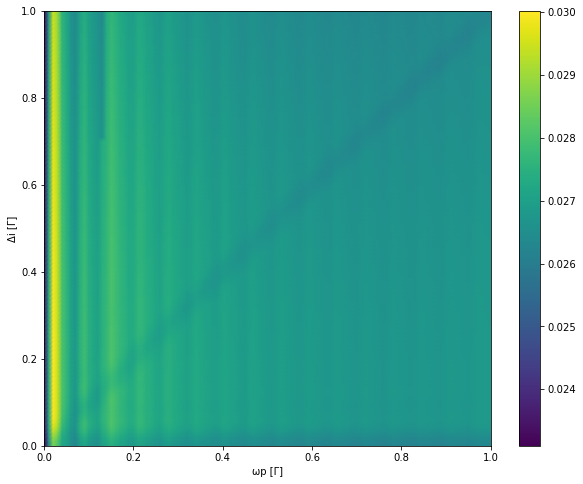

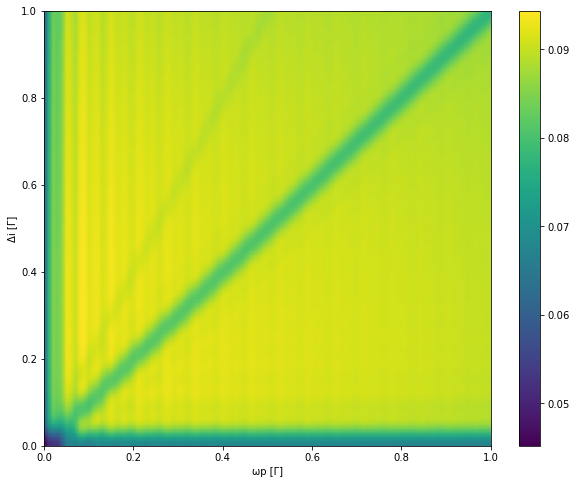

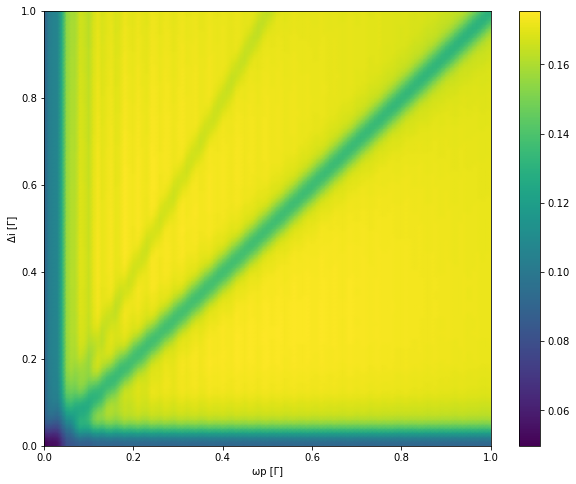

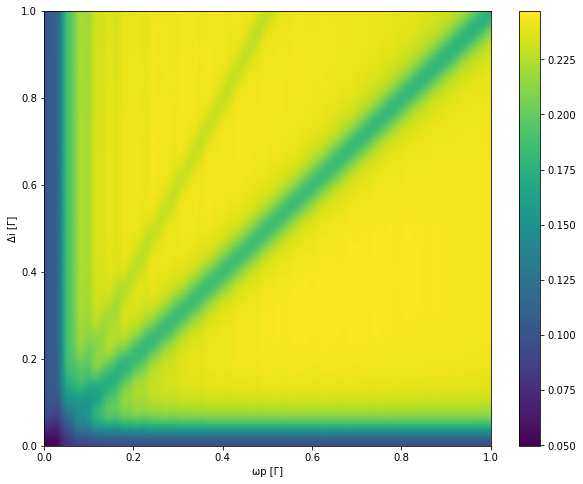

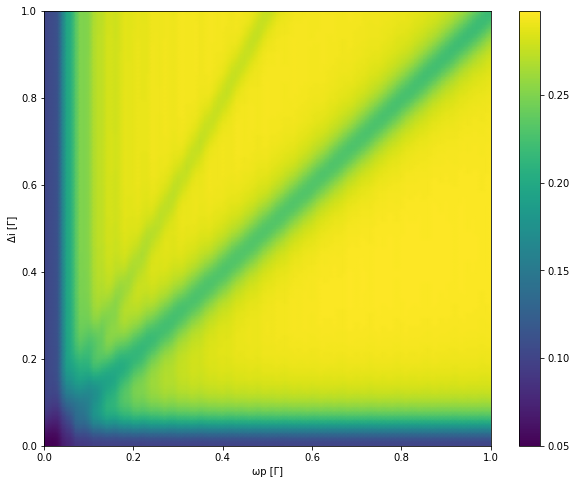

In [89]:
X,Y = np.meshgrid(*values[::-1][1:])
for s in sol_even_spread[::2]:
    fig, ax = plt.subplots(figsize = (10,8))
    cax = ax.pcolormesh(X,Y,s, shading = 'gouraud')
    fig.colorbar(cax)
    ax.set_xlabel('ωp [Γ]')
    ax.set_ylabel('Δi [Γ]');

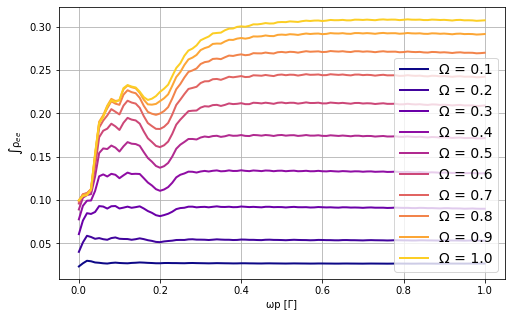

In [88]:
import matplotlib as mpl

Δi = 0.2

cmap = mpl.cm.get_cmap("plasma")
dy = 0.

maxval = np.max(sol_even_spread_unshaped[params[:,0]==Δi])
    
fig, ax = plt.subplots(figsize = (8,5))
for i,Ωi in enumerate(Ωis):
    m = (params[:,0] == Δi) & (params[:,2] == Ωi)
    ax.plot(ωis, sol_even_spread_unshaped[m]+dy*i, lw = 2, color = cmap(i/len(Ωis)), label = f"Ω = {Ωi:.1f}")
#     ax.fill_between(ωis, dy*i, sol_unshaped[m]+dy*i, color = cmap(i/len(Ωis)), alpha = 1, zorder = 100-i)

ax.legend(fontsize = 14)
ax.set_xlabel('ωp [Γ]')
ax.set_ylabel("$\int$ρ$_{ee}$")
ax.grid(True);

## Population in a single state (1st level)
Scanning the polarization switching frequency, rabi rate and splitting for a fixed detuning of 0

In [123]:
Δis = np.linspace(0,1,101)
ωis = np.linspace(0,1,101)
Ωis = np.linspace(0.1,1,10)

In [124]:
Main.eval("""
@everywhere begin
    ρᵢ = zeros(ComplexF64,7,7)
    ρᵢ[1,1] = 1
    u0 = [ρ[idx,idy] => ρᵢ[idx,idy] for idx in 1:7 for idy in 1:7]
    prob = ODEProblem(system, u0, (0., 100.), p, jac = true)
end
""");

In [125]:
Main.eval("""
@everywhere function output_func_progress(sol, i)
    put!(channel, 1)
    return output_func(sol, i)
end
""")

In [126]:
values = [Δis, ωis, Ωis]
params = np.array(np.meshgrid(*values)).T.reshape(-1,len(values))
Main.params = params
Main.eval("@everywhere params = $params")

In [127]:
Main.eval(f"""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = ModelingToolkit.varmap_to_vars([Δ=>params[i,1], ωp=>params[i,2],
        Ωl => params[i,3], ϕp => 0, δ1 => 0, Γ1 => 1, Γ2 => 1, icomplex => 1im],
        parameters(system)))
end
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sol.u[j][49]) for j in 1:size(sol)[2]]), false
end
""")

In [128]:
Main.eval("""
    ens_prob = EnsembleProblem(prob, output_func = output_func_progress, prob_func = prob_func)
""");

In [129]:
Main.eval("""
progress = Progress(size(params)[1], showspeed = true)
n_trajectories = size(params)[1]
@sync sol = begin
    @async begin
        tasksdone = 0
        while tasksdone < n_trajectories
            tasksdone += take!(channel)
            update!(progress, tasksdone)
        end
    end
    @async begin
        global sol = solve(ens_prob, Tsit5(), EnsembleDistributed(), trajectories=n_trajectories, 
                    reltol = 1e-7, abstol = 1e-4)
    end
end
""");

In [130]:
sol_unshaped = np.asarray(Main.eval("sol"))
sol = np.asarray(Main.eval("sol")).reshape(len(Ωis),len(Δis),len(ωis))
sol_single_unshaped = sol_unshaped.copy()
sol_single = sol.copy()

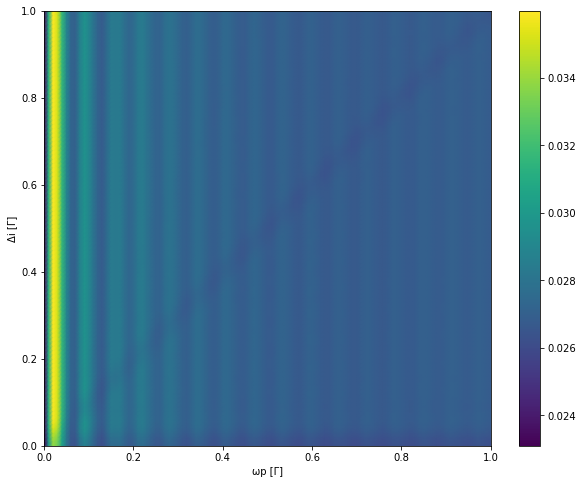

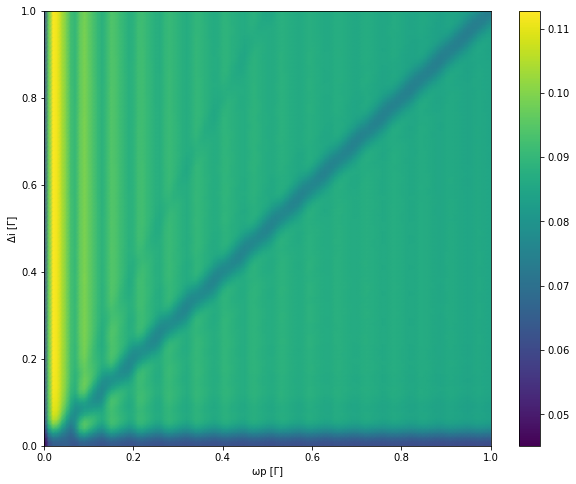

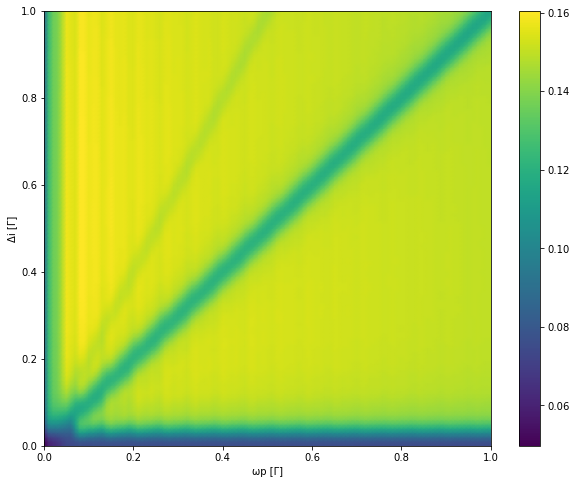

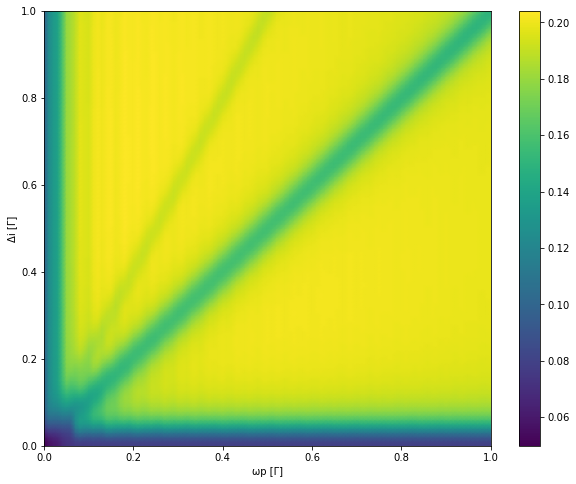

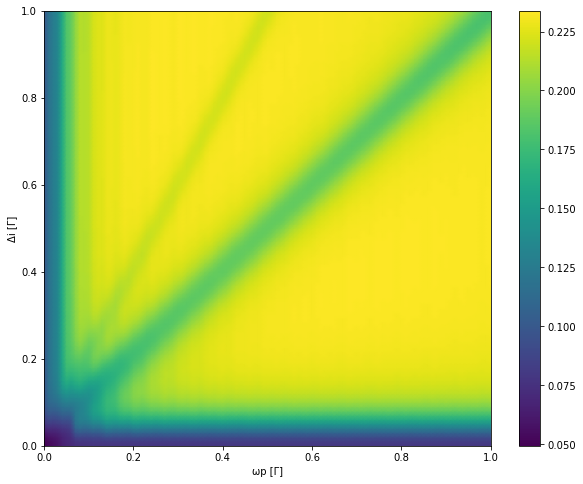

In [131]:
X,Y = np.meshgrid(*values[::-1][1:])
for s in sol_single[::2]:
    fig, ax = plt.subplots(figsize = (10,8))
    cax = ax.pcolormesh(X,Y,s, shading = 'gouraud')
    fig.colorbar(cax)
    ax.set_xlabel('ωp [Γ]')
    ax.set_ylabel('Δi [Γ]');

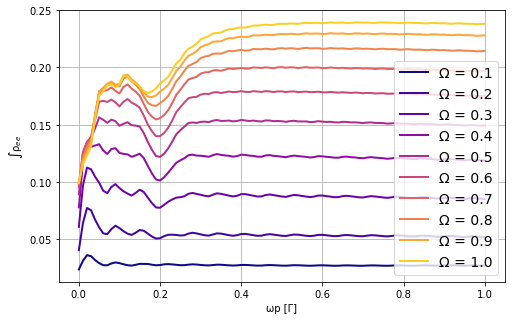

In [132]:
import matplotlib as mpl

Δi = 0.2

cmap = mpl.cm.get_cmap("plasma")
dy = 0.

maxval = np.max(sol_unshaped[params[:,0]==Δi])
    
fig, ax = plt.subplots(figsize = (8,5))
for i,Ωi in enumerate(Ωis):
    m = (params[:,0] == Δi) & (params[:,2] == Ωi)
    ax.plot(ωis, sol_single_unshaped[m]+dy*i, lw = 2, color = cmap(i/len(Ωis)), label = f"Ω = {Ωi:.1f}")
#     ax.fill_between(ωis, dy*i, sol_unshaped[m]+dy*i, color = cmap(i/len(Ωis)), alpha = 1, zorder = 100-i)

ax.legend(fontsize = 14)
ax.set_xlabel('ωp [Γ]')
ax.set_ylabel("$\int$ρ$_{ee}$")
ax.grid(True);

## Population in a single state (1st level)
Scanning the polarization switching frequency, rabi rate and splitting for a fixed detuning of half the splitting

In [103]:
Δis = np.linspace(0,1,101)
ωis = np.linspace(0,1,101)
Ωis = np.linspace(0.1,1,10)

In [104]:
Main.eval("""
@everywhere begin
    ρᵢ = zeros(ComplexF64,7,7)
    ρᵢ[1,1] = 1
    u0 = [ρ[idx,idy] => ρᵢ[idx,idy] for idx in 1:7 for idy in 1:7]
    prob = ODEProblem(system, u0, (0., 100.), p, jac = true)
end
""");

In [105]:
Main.eval("""
@everywhere function output_func_progress(sol, i)
    put!(channel, 1)
    return output_func(sol, i)
end
""")

In [106]:
values = [Δis, ωis, Ωis]
params = np.array(np.meshgrid(*values)).T.reshape(-1,len(values))
Main.params = params
Main.eval("@everywhere params = $params")

In [107]:
Main.eval(f"""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = ModelingToolkit.varmap_to_vars([Δ=>params[i,1], ωp=>params[i,2],
        Ωl => params[i,3], ϕp => 0, δ1 => params[i,1]/2, Γ1 => 1, Γ2 => 1, icomplex => 1im],
        parameters(system)))
end
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sol.u[j][49]) for j in 1:size(sol)[2]]), false
end
""")

In [108]:
Main.eval("""
    ens_prob = EnsembleProblem(prob, output_func = output_func_progress, prob_func = prob_func)
""");

In [109]:
Main.eval("""
progress = Progress(size(params)[1], showspeed = true)
n_trajectories = size(params)[1]
@sync sol = begin
    @async begin
        tasksdone = 0
        while tasksdone < n_trajectories
            tasksdone += take!(channel)
            update!(progress, tasksdone)
        end
    end
    @async begin
        global sol = solve(ens_prob, Tsit5(), EnsembleDistributed(), trajectories=n_trajectories, 
                    reltol = 1e-7, abstol = 1e-4)
    end
end
""");

In [113]:
sol_unshaped = np.asarray(Main.eval("sol"))
sol = np.asarray(Main.eval("sol")).reshape(len(Ωis),len(Δis),len(ωis))
sol_single_unshaped_δadj = sol_unshaped.copy()
sol_single_δadj = sol.copy()

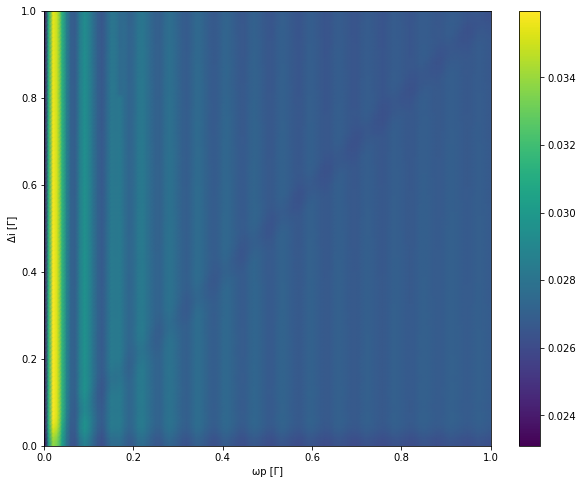

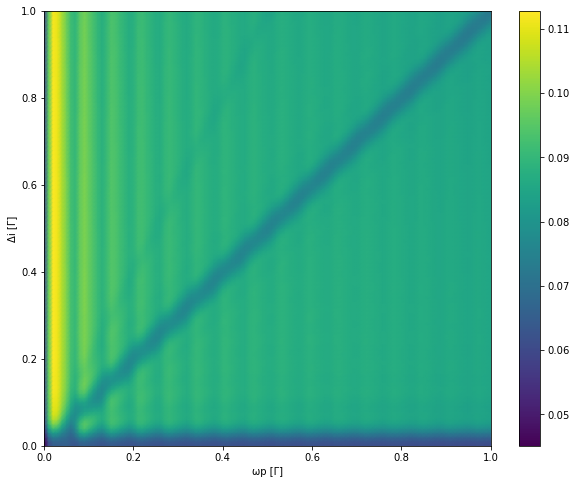

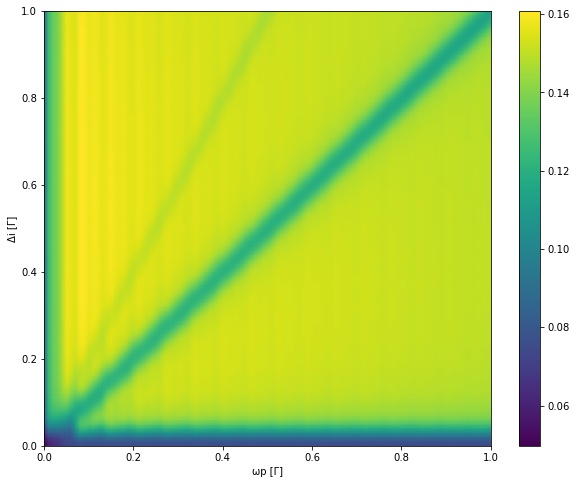

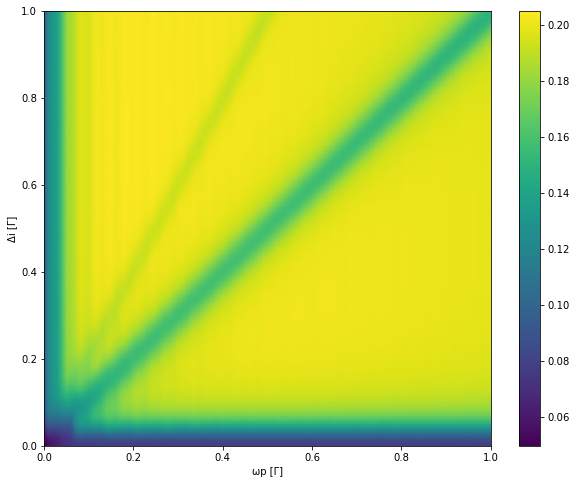

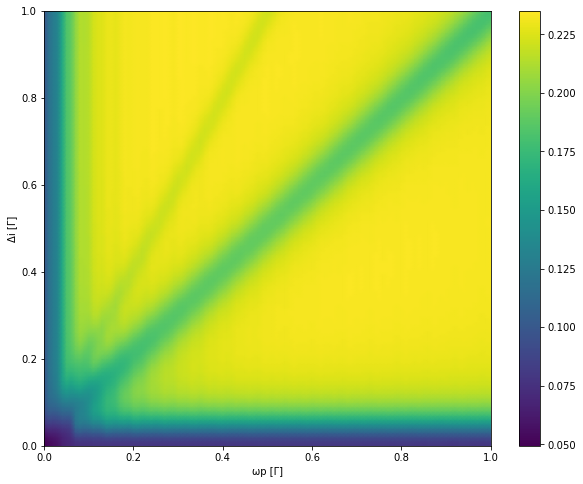

In [114]:
X,Y = np.meshgrid(*values[::-1][1:])
for s in sol_single_δadj[::2]:
    fig, ax = plt.subplots(figsize = (10,8))
    cax = ax.pcolormesh(X,Y,s, shading = 'gouraud')
    fig.colorbar(cax)
    ax.set_xlabel('ωp [Γ]')
    ax.set_ylabel('Δi [Γ]');

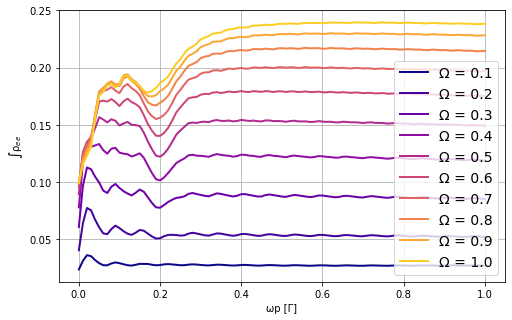

In [145]:
import matplotlib as mpl

Δi = 0.2

cmap = mpl.cm.get_cmap("plasma")
dy = 0.

maxval = np.max(sol_unshaped[params[:,0]==Δi])
    
fig, ax = plt.subplots(figsize = (8,5))
for i,Ωi in enumerate(Ωis):
    m = (params[:,0] == Δi) & (params[:,2] == Ωi)
    ax.plot(ωis, sol_single_unshaped_δadj[m]+dy*i, lw = 2, color = cmap(i/len(Ωis)), label = f"Ω = {Ωi:.1f}")
#     ax.fill_between(ωis, dy*i, sol_unshaped[m]+dy*i, color = cmap(i/len(Ωis)), alpha = 1, zorder = 100-i)

ax.legend(fontsize = 14)
ax.set_xlabel('ωp [Γ]')
ax.set_ylabel("$\int$ρ$_{ee}$")
ax.grid(True);

## Population evenly spread out
Scanning the polarization switching frequency, rabi rate and splitting for a fixed detuning of 0

In [135]:
Main.eval("""
@everywhere begin
    ρᵢ = zeros(ComplexF64,7,7)
    ρᵢ[1,1] = 1/6
    ρᵢ[2,2] = 1/6
    ρᵢ[3,3] = 1/6
    ρᵢ[4,4] = 1/6
    ρᵢ[5,5] = 1/6
    ρᵢ[6,6] = 1/6
    u0 = [ρ[idx,idy] => ρᵢ[idx,idy] for idx in 1:7 for idy in 1:7]
    prob = ODEProblem(system, u0, (0., 100.), p, jac = true)
end
""");

In [136]:
Δis = np.linspace(0,1,101)
ωis = np.linspace(0,1,101)
Ωis = np.linspace(0.1,1,10)

In [137]:
values = [Δis, ωis, Ωis]
params = np.array(np.meshgrid(*values)).T.reshape(-1,len(values))
Main.params = params
Main.eval("@everywhere params = $params")

In [138]:
Main.eval(f"""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = ModelingToolkit.varmap_to_vars([Δ=>params[i,1], ωp=>params[i,2],
        Ωl => params[i,3], ϕp => 0, δ1 => params[i,1]/2, Γ1 => 1, Γ2 => 1, icomplex => 1im],
        parameters(system)))
end
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sol.u[j][49]) for j in 1:size(sol)[2]]), false
end
""")

In [139]:
Main.eval("""
    ens_prob = EnsembleProblem(prob, output_func = output_func_progress, prob_func = prob_func)
""");

In [140]:
Main.eval("""
progress = Progress(size(params)[1], showspeed = true)
n_trajectories = size(params)[1]
@sync sol = begin
    @async begin
        tasksdone = 0
        while tasksdone < n_trajectories
            tasksdone += take!(channel)
            update!(progress, tasksdone)
        end
    end
    @async begin
        global sol = solve(ens_prob, Tsit5(), EnsembleDistributed(), trajectories=n_trajectories, 
                    reltol = 1e-7, abstol = 1e-4)
    end
end
""");

In [141]:
sol_unshaped = np.asarray(Main.eval("sol"))
sol = np.asarray(Main.eval("sol")).reshape(len(Ωis),len(Δis),len(ωis))
sol_even_spread_unshaped_δadj = sol_unshaped.copy()
sol_even_spread_δadj = sol.copy()

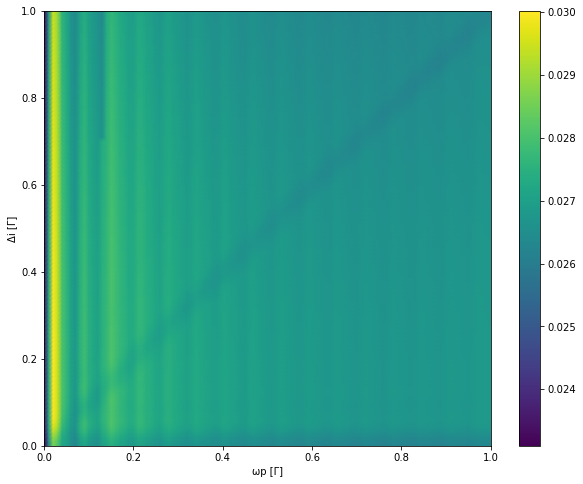

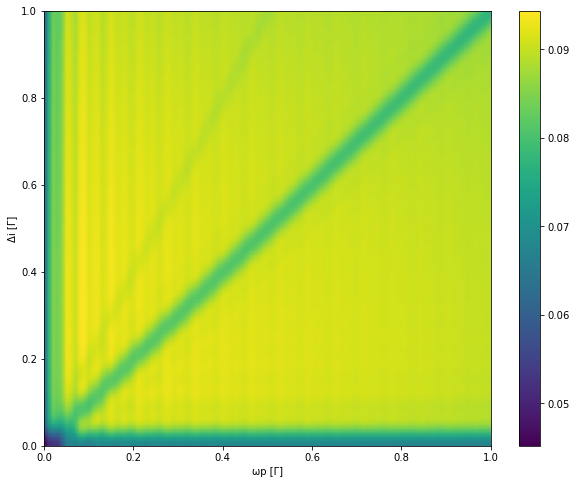

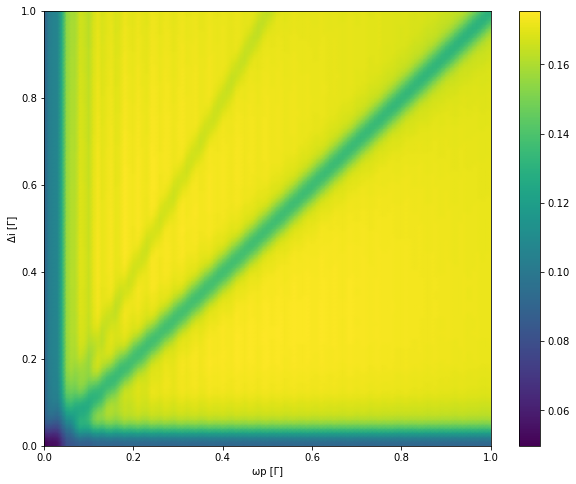

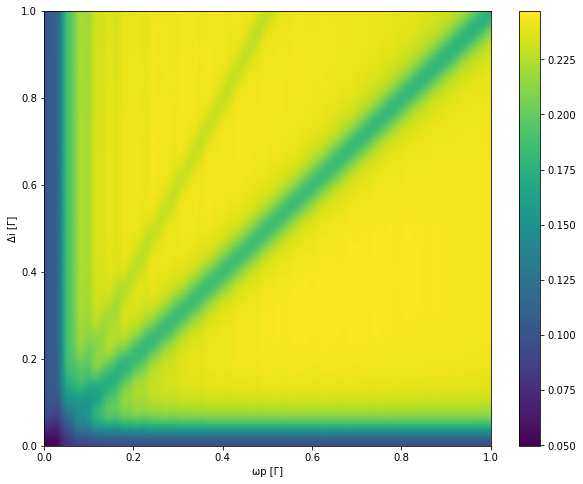

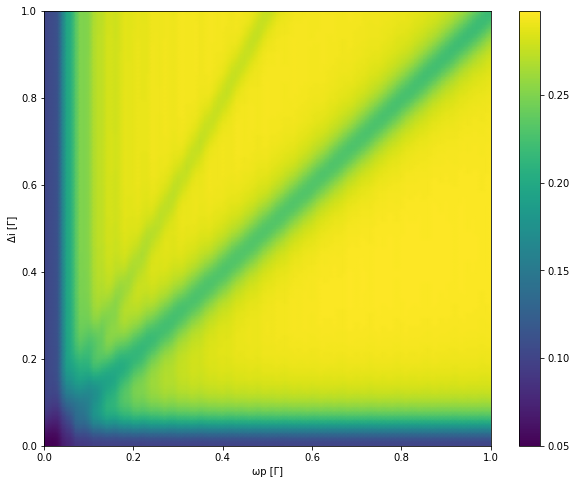

In [142]:
X,Y = np.meshgrid(*values[::-1][1:])
for s in sol_even_spread_δadj[::2]:
    fig, ax = plt.subplots(figsize = (10,8))
    cax = ax.pcolormesh(X,Y,s, shading = 'gouraud')
    fig.colorbar(cax)
    ax.set_xlabel('ωp [Γ]')
    ax.set_ylabel('Δi [Γ]');

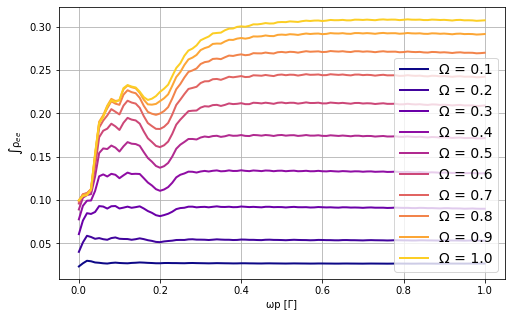

In [148]:
import matplotlib as mpl

Δi = 0.2

cmap = mpl.cm.get_cmap("plasma")
dy = 0.

maxval = np.max(sol_even_spread_unshaped[params[:,0]==Δi])
    
fig, ax = plt.subplots(figsize = (8,5))
for i,Ωi in enumerate(Ωis):
    m = (params[:,0] == Δi) & (params[:,2] == Ωi)
    ax.plot(ωis, sol_even_spread_unshaped_δadj[m]+dy*i, lw = 2, color = cmap(i/len(Ωis)), label = f"Ω = {Ωi:.1f}")
#     ax.fill_between(ωis, dy*i, sol_unshaped[m]+dy*i, color = cmap(i/len(Ωis)), alpha = 1, zorder = 100-i)

ax.legend(fontsize = 14)
ax.set_xlabel('ωp [Γ]')
ax.set_ylabel("$\int$ρ$_{ee}$")
ax.grid(True);

## Scan detuning for evenly spread population

In [135]:
Main.eval("""
@everywhere begin
    ρᵢ = zeros(ComplexF64,7,7)
    ρᵢ[1,1] = 1/6
    ρᵢ[2,2] = 1/6
    ρᵢ[3,3] = 1/6
    ρᵢ[4,4] = 1/6
    ρᵢ[5,5] = 1/6
    ρᵢ[6,6] = 1/6
    u0 = [ρ[idx,idy] => ρᵢ[idx,idy] for idx in 1:7 for idy in 1:7]
    prob = ODEProblem(system, u0, (0., 100.), p, jac = true)
end
""");

In [157]:
δis = np.linspace(-2,2,101)
Ωis = np.linspace(0.1,1,10)

In [158]:
values = [δis, Ωis]
params = np.array(np.meshgrid(*values)).T.reshape(-1,len(values))
Main.params = params
Main.eval("@everywhere params = $params")

In [164]:
Main.eval(f"""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = ModelingToolkit.varmap_to_vars([Δ=>0.5, ωp=>0.4,
        Ωl => params[i,2], ϕp => 0, δ1 => params[i,1], Γ1 => 1, Γ2 => 1, icomplex => 1im],
        parameters(system)))
end
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sol.u[j][49]) for j in 1:size(sol)[2]]), false
end
""")

In [165]:
Main.eval("""
    ens_prob = EnsembleProblem(prob, output_func = output_func_progress, prob_func = prob_func)
""");

In [166]:
Main.eval("""
progress = Progress(size(params)[1], showspeed = true)
n_trajectories = size(params)[1]
@sync sol = begin
    @async begin
        tasksdone = 0
        while tasksdone < n_trajectories
            tasksdone += take!(channel)
            update!(progress, tasksdone)
        end
    end
    @async begin
        global sol = solve(ens_prob, Tsit5(), EnsembleDistributed(), trajectories=n_trajectories, 
                    reltol = 1e-7, abstol = 1e-4)
    end
end
""");

In [167]:
sol_unshaped = np.asarray(Main.eval("sol"))
sol = np.asarray(Main.eval("sol")).reshape(*[len(val) for val in values])

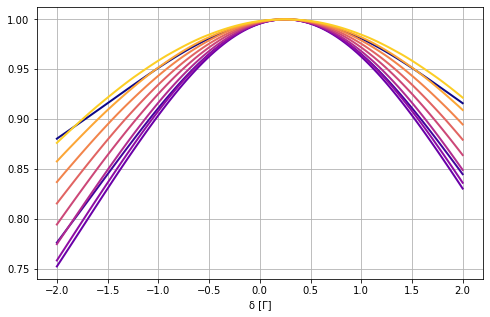

In [168]:
cmap = mpl.cm.get_cmap("plasma")

fig, ax = plt.subplots(figsize = (8,5))
for i in range(10):
    ax.plot(δis, sol[:,i]/sol[:,i].max(), lw = 2, color = cmap(i/len(Ωis)))
    ax.set_xlabel("δ [Γ]");
ax.grid(True)

In [135]:
Main.eval("""
@everywhere begin
    ρᵢ = zeros(ComplexF64,7,7)
    ρᵢ[1,1] = 1/6
    ρᵢ[2,2] = 1/6
    ρᵢ[3,3] = 1/6
    ρᵢ[4,4] = 1/6
    ρᵢ[5,5] = 1/6
    ρᵢ[6,6] = 1/6
    u0 = [ρ[idx,idy] => ρᵢ[idx,idy] for idx in 1:7 for idy in 1:7]
    prob = ODEProblem(system, u0, (0., 100.), p, jac = true)
end
""");

In [235]:
δis = np.linspace(0,1,11)
ωis = np.linspace(0,1,201)
Ωis = np.linspace(0.1,1,10)

In [236]:
values = [δis, ωis, Ωis]
params = np.array(np.meshgrid(*values)).T.reshape(-1,len(values))
Main.params = params
Main.eval("@everywhere params = $params")

In [237]:
Main.eval(f"""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = ModelingToolkit.varmap_to_vars([Δ=>0.5, ωp=>params[i,2],
        Ωl => params[i,3], ϕp => 0, δ1 => params[i,1], Γ1 => 1, Γ2 => 1, icomplex => 1im],
        parameters(system)))
end
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sol.u[j][49]) for j in 1:size(sol)[2]]), false
end
""")

In [238]:
Main.eval("""
    ens_prob = EnsembleProblem(prob, output_func = output_func_progress, prob_func = prob_func)
""");

In [239]:
Main.eval("""
progress = Progress(size(params)[1], showspeed = true)
n_trajectories = size(params)[1]
@sync sol = begin
    @async begin
        tasksdone = 0
        while tasksdone < n_trajectories
            tasksdone += take!(channel)
            update!(progress, tasksdone)
        end
    end
    @async begin
        global sol = solve(ens_prob, Tsit5(), EnsembleDistributed(), trajectories=n_trajectories, 
                    reltol = 1e-8, abstol = 1e-5)
    end
end
""");

In [240]:
sol_unshaped = np.asarray(Main.eval("sol"))
sol = np.asarray(Main.eval("sol")).reshape(*[len(Ωis), len(δis), len(ωis)])

In [241]:
sol.shape

(10, 11, 201)

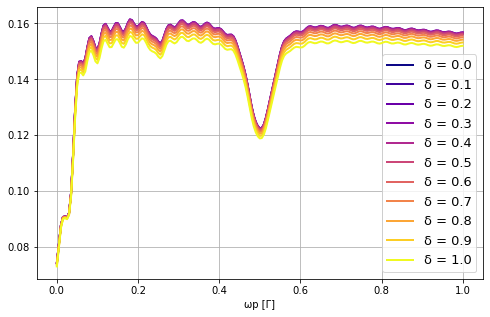

In [253]:
cmap = mpl.cm.get_cmap("plasma")

fig, ax = plt.subplots(figsize = (8,5))
for i,δi in enumerate(δis):
    ax.plot(ωis, sol[4,i,:], lw = 2, color = cmap(i/len(Ωis)), label = f'δ = {δi:.1f}')
    ax.set_xlabel("ωp [Γ]");
ax.legend(fontsize = 13)
ax.grid(True)